### timeseries of biological and environmental variables from CESM2-4p2z model run

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np

import ncar_jobqueue
from dask.distributed import Client

import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 
import pandas as pd
import cftime
import matplotlib.colors as colors
import utils

In [2]:
case = 'g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.002branch'
obs_dir = '/glade/campaign/cesm/development/bgcwg/projects/CESM2-OMIP2-like-4p2z-run/' + case + '/ocn/proc/tseries/month_1/'

###  grab desired variables

In [3]:
variables = ['PH','SHF_QSW','DIC','NO3','TEMP',
             'HMXL','coccoC','coccoCaCO3','diatC',
             'spC','diatSi','Fe','cocco_Fe_lim_Cweight_avg_100m',
             'cocco_N_lim_Cweight_avg_100m','IRON_FLUX']

### define the data range

In [4]:
ds_fosi = xr.Dataset()
#ds_fosi_seas = xr.Dataset()

for var in variables:
    
    print('starting on ', var)
    ################ FOSI
    
    ds_tmp = xr.open_dataset(obs_dir + case + '.pop.h.' + var + '.195801-202112.nc')
    
    keep_vars=['z_t','z_t_150m','time_bound','dz','TLAT','TLONG','time'] + [var]

    ds_tmp = ds_tmp.drop([v for v in ds_tmp.variables if v not in keep_vars])
    
    ds_fosi = xr.merge([ds_fosi,ds_tmp],combine_attrs='override')

starting on  PH
starting on  SHF_QSW
starting on  DIC
starting on  NO3
starting on  TEMP
starting on  HMXL
starting on  coccoC
starting on  coccoCaCO3
starting on  diatC
starting on  spC
starting on  diatSi
starting on  Fe
starting on  cocco_Fe_lim_Cweight_avg_100m
starting on  cocco_N_lim_Cweight_avg_100m
starting on  IRON_FLUX


In [5]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=2,
        memory='25 GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=25GB',
        project='NCGD0011',
        walltime='05:00:00',
        interface='ext',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

In [6]:
cluster, client = get_ClusterClient()
cluster.scale(12) 
client

Client Scheduler: tcp://128.117.208.88:42781 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kristenk/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


### Integrate phytoplankton vars

In [7]:
attrs = ds_fosi['diatC'].attrs
ds_fosi['diatC']= (ds_fosi['diatC'].isel(z_t_150m=slice(0,10))*10.).sum(dim='z_t_150m')
ds_fosi['diatC'].attrs = attrs
ds_fosi['diatC'].attrs['units'] = 'mmol/m^2'
        
attrs = ds_fosi['coccoC'].attrs
ds_fosi['coccoC']= (ds_fosi['coccoC'].isel(z_t_150m=slice(0,10))*10.).sum(dim='z_t_150m')
ds_fosi['coccoC'].attrs = attrs
ds_fosi['coccoC'].attrs['units'] = 'mmol/m^2'

attrs = ds_fosi['coccoCaCO3'].attrs
ds_fosi['coccoCaCO3']= (ds_fosi['coccoCaCO3'].isel(z_t_150m=slice(0,10))*10.).sum(dim='z_t_150m')
ds_fosi['coccoCaCO3'].attrs = attrs
ds_fosi['coccoCaCO3'].attrs['units'] = 'mmol/m^2'

attrs = ds_fosi['diatSi'].attrs
ds_fosi['diatSi']= (ds_fosi['diatSi'].isel(z_t_150m=slice(0,10))*10.).sum(dim='z_t_150m')
ds_fosi['diatSi'].attrs = attrs
ds_fosi['diatSi'].attrs['units'] = 'mmol/m^2'

attrs = ds_fosi['spC'].attrs
ds_fosi['spC']= (ds_fosi['spC'].isel(z_t_150m=slice(0,10))*10.).sum(dim='z_t_150m')
ds_fosi['spC'].attrs = attrs
ds_fosi['spC'].attrs['units'] = 'mmol/m^2'

### make top 100m of environmental variables

In [8]:
%%time

attrs = ds_fosi['TEMP'].attrs
ds_fosi['TEMP']= (ds_fosi['TEMP'].isel(z_t=slice(0,10))).mean(dim='z_t') # top 100m mean
ds_fosi['TEMP'].attrs = attrs
ds_fosi['TEMP'].attrs['long_name'] = 'top 100 m mean temperature'

print('temp done')

attrs = ds_fosi['DIC'].attrs
ds_fosi['DIC']= (ds_fosi['DIC'].isel(z_t=slice(0,10))).mean(dim='z_t') # top 100m mean
ds_fosi['DIC'].attrs = attrs
ds_fosi['DIC'].attrs['long_name'] = 'top 100 m mean dissolved inorganic carbon'

print('dic done')

attrs = ds_fosi['Fe'].attrs
ds_fosi['Fe']= (ds_fosi['Fe'].isel(z_t=slice(0,10))).mean(dim='z_t') # top 100m mean
ds_fosi['Fe'].attrs = attrs
ds_fosi['Fe'].attrs['long_name'] = 'top 100 m mean dissolved inorganic iron'

print('fe done')

attrs = ds_fosi['NO3'].attrs
ds_fosi['NO3']= (ds_fosi['NO3'].isel(z_t=slice(0,10))).mean(dim='z_t') # top 100m mean
ds_fosi['NO3'].attrs = attrs
ds_fosi['NO3'].attrs['long_name'] = 'top 100 m mean dissolved inorganic nitrate'

temp done
dic done
fe done
CPU times: user 5min 31s, sys: 34.3 s, total: 6min 5s
Wall time: 7min 7s


### get coords and make a ones array for masking

In [9]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
lats = ds_grid.TLAT
lons = ds_grid.TLONG
area = ds_grid.TAREA
area_m = area * 1.e-4
area_km = area * 1.e-10
lons_norm = utils.normal_lons(lons)

In [10]:
ones = np.full((384,320),1,dtype=int)
ones = xr.DataArray(ones,dims=('nlat','nlon'))
ones = ones.where(ds_grid.REGION_MASK>0)

In [11]:
#ds_fosi_seas = ds_fosi_seas.where(ds_grid.REGION_MASK>0)

### Sample the dataset for annual

In [12]:
ds_fosi["time"] = ds_fosi.time_bound.compute().mean(dim="d2")

In [13]:
%%time
ds_fosi_ann = ds_fosi.resample({'time':'A'}, keep_attrs=True).mean(dim='time', keep_attrs=True).compute()

CPU times: user 1min 18s, sys: 1.94 s, total: 1min 20s
Wall time: 1min 32s


In [14]:
ds_djf = xr.Dataset()
ds_jja = xr.Dataset() # for calculating SIZ mask, whether or not the wintertime ifrac makes a big difference for the following growing season
ds_son = xr.Dataset()

sp = 8 # sept index , rearing period (rp)
i = 5 # june index for jja averages
s = 11 #december index for djf averages, summer (s)

for year in np.arange(0,63,1):
        
        print(year,sp,s,i)
    
        
        ### JJA
        jja = ds_fosi.isel(time=slice(i,i+3)).mean(dim='time')

        ds_jja = xr.concat([ds_jja,jja],dim='time')

        i = i + 12
        
                
        ### SON
        son = ds_fosi.isel(time=slice(sp,sp+3)).mean(dim='time')

        ds_son = xr.concat([ds_son,son],dim='time')

        sp = sp + 12
        
                        
        ### DJF
        djf = ds_fosi.isel(time=slice(s,s+3)).mean(dim='time')

        ds_djf = xr.concat([ds_djf,djf],dim='time')

        s = s + 12

0 8 11 5
1 20 23 17
2 32 35 29
3 44 47 41
4 56 59 53
5 68 71 65
6 80 83 77
7 92 95 89
8 104 107 101
9 116 119 113
10 128 131 125
11 140 143 137
12 152 155 149
13 164 167 161
14 176 179 173
15 188 191 185
16 200 203 197
17 212 215 209
18 224 227 221
19 236 239 233
20 248 251 245
21 260 263 257
22 272 275 269
23 284 287 281
24 296 299 293
25 308 311 305
26 320 323 317
27 332 335 329
28 344 347 341
29 356 359 353
30 368 371 365
31 380 383 377
32 392 395 389
33 404 407 401
34 416 419 413
35 428 431 425
36 440 443 437
37 452 455 449
38 464 467 461
39 476 479 473
40 488 491 485
41 500 503 497
42 512 515 509
43 524 527 521
44 536 539 533
45 548 551 545
46 560 563 557
47 572 575 569
48 584 587 581
49 596 599 593
50 608 611 605
51 620 623 617
52 632 635 629
53 644 647 641
54 656 659 653
55 668 671 665
56 680 683 677
57 692 695 689
58 704 707 701
59 716 719 713
60 728 731 725
61 740 743 737
62 752 755 749


### Write out annual mean dataset and DJF mean dataset

In [15]:
ds_djf

<xarray.Dataset>
Dimensions:                        (nlat: 384, nlon: 320, time: 63, z_t: 60, z_t_150m: 15)
Coordinates:
    TLONG                          (nlat, nlon) float64 320.6 321.7 ... nan nan
    TLAT                           (nlat, nlon) float64 -79.22 -79.22 ... nan
  * z_t                            (z_t) float32 500.0 1.5e+03 ... 5.375e+05
  * z_t_150m                       (z_t_150m) float32 500.0 1.5e+03 ... 1.45e+04
Dimensions without coordinates: nlat, nlon, time
Data variables: (12/16)
    spC                            (time, nlat, nlon) float32 0.0 0.0 ... 0.0
    TEMP                           (time, nlat, nlon) float32 nan nan ... nan
    cocco_N_lim_Cweight_avg_100m   (time, nlat, nlon) float32 nan nan ... nan
    IRON_FLUX                      (time, nlat, nlon) float32 nan nan ... nan
    HMXL                           (time, nlat, nlon) float32 nan nan ... nan
    diatC                          (time, nlat, nlon) float32 0.0 0.0 ... 0.0
    ...                             ...
    cocco_Fe_lim_Cweight_avg_100m  (time, nlat, nlon) float32 nan nan ... nan
    dz                             (time, z_t) float32 1e+03 1e+03 ... 2.5e+04
    coccoCaCO3                     (time, nlat, nlon) float32 0.0 0.0 ... 0.0
    SHF_QSW                        (time, nlat, nlon) float32 nan nan ... nan
    PH                             (time, nlat, nlon) float32 nan nan ... nan
    coccoC                         (time, nlat, nlon) float32 0.0 0.0 ... 0.0

In [16]:
# ds_djf.to_netcdf('/glade/scratch/kristenk/data_SOcocco/DJF_dataset1.nc', mode='w')
# ds_jja.to_netcdf('/glade/scratch/kristenk/data_SOcocco/JJA_dataset1.nc', mode='w')
# ds_son.to_netcdf('/glade/scratch/kristenk/data_SOcocco/SON_dataset1.nc', mode='w')
# ds_fosi_ann.to_netcdf('/glade/scratch/kristenk/data_SOcocco/annual_dataset1.nc', mode='w')

ds_djf = xr.open_dataset('/glade/scratch/kristenk/data_SOcocco/DJF_dataset1.nc')
ds_jja = xr.open_dataset('/glade/scratch/kristenk/data_SOcocco/JJA_dataset1.nc')
ds_son = xr.open_dataset('/glade/scratch/kristenk/data_SOcocco/SON_dataset1.nc')
ds_fosi_ann = xr.open_dataset('/glade/scratch/kristenk/data_SOcocco/annual_dataset1.nc')

### Make a climatology

In [17]:
ds_clim = ds_fosi.groupby('time.month').mean('time')

In [18]:
ds_clim['perc_cocco']=ds_clim.coccoC / (ds_clim.diatC + ds_clim.coccoC + ds_clim.spC) * 100.

In [19]:
ds_clim['perc_diat']=ds_clim.diatC / (ds_clim.diatC + ds_clim.coccoC + ds_clim.spC) * 100.

In [20]:
ds_clim['perc_sp']=ds_clim.spC / (ds_clim.diatC + ds_clim.coccoC + ds_clim.spC) * 100.

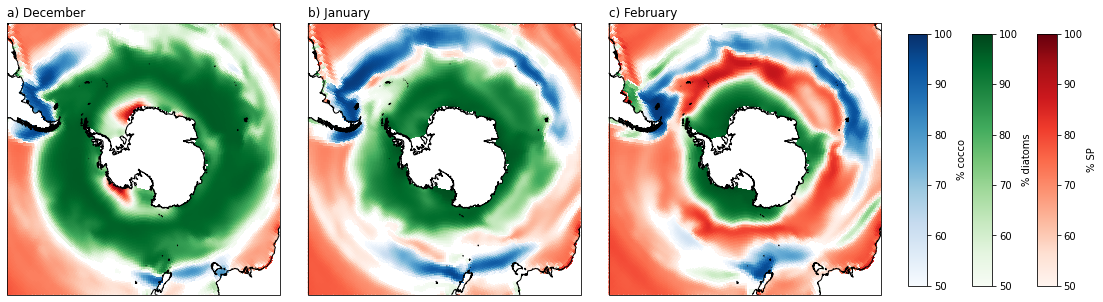

In [21]:
fig = plt.figure(figsize=(18,5))

############### 
ax = fig.add_subplot(1,3,1, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
ax.set_title('a) December', loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_clim.perc_cocco.isel(month=11).where(ds_clim.perc_cocco.isel(month=11)>50))
pc_c = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='Blues',vmin=50,vmax=100)

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_clim.perc_diat.isel(month=11).where(ds_clim.perc_diat.isel(month=11)>50))
pc_d = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='Greens',vmin=50,vmax=100)

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_clim.perc_sp.isel(month=11).where(ds_clim.perc_sp.isel(month=11)>50))
pc_s = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='Reds',vmin=50,vmax=100)


ax.coastlines('10m',linewidth=1)


############### 
ax = fig.add_subplot(1,3,2, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
ax.set_title('b) January', loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_clim.perc_cocco.isel(month=0).where(ds_clim.perc_cocco.isel(month=0)>50))
pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='Blues',vmin=50,vmax=100)

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_clim.perc_diat.isel(month=0).where(ds_clim.perc_diat.isel(month=0)>50))
pc_d = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='Greens',vmin=50,vmax=100)

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_clim.perc_sp.isel(month=0).where(ds_clim.perc_sp.isel(month=0)>50))
pc_s = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='Reds',vmin=50,vmax=100)


ax.coastlines('10m',linewidth=1)


############### 
ax = fig.add_subplot(1,3,3, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
ax.set_title('c) February', loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_clim.perc_cocco.isel(month=1).where(ds_clim.perc_cocco.isel(month=1)>50))
pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='Blues',vmin=50,vmax=100)

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_clim.perc_diat.isel(month=1).where(ds_clim.perc_diat.isel(month=1)>50))
pc_d = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='Greens',vmin=50,vmax=100)

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_clim.perc_sp.isel(month=1).where(ds_clim.perc_sp.isel(month=1)>50))
pc_s = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='Reds',vmin=50,vmax=100)

ax.coastlines('10m',linewidth=1)

##########################################################


##########################################################

fig.subplots_adjust(right=0.8, wspace=0.1)

cbar_ax = fig.add_axes([0.82, 0.15, 0.015, 0.7])
cbar1 = fig.colorbar(pc_c, cax=cbar_ax,label='% cocco')

cbar_ax = fig.add_axes([0.87, 0.15, 0.015, 0.7])
cbar1 = fig.colorbar(pc_d, cax=cbar_ax,label='% diatoms')

cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
cbar1 = fig.colorbar(pc_s, cax=cbar_ax,label='% SP')

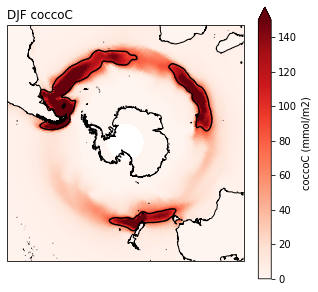

In [22]:
fig = plt.figure(figsize=(18,5))
contour_specs = {'levels': np.arange(-0.6,0.7,0.1)}
siz_lev = [0.5]
############### 
ax = fig.add_subplot(1,3,1, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax.set_title('DJF coccoC', loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_djf.coccoC.mean(dim='time'))

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='Reds',vmin=0,vmax=150)

cocco_lev = [90]
lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_djf.coccoC.mean(dim='time'))
cs = ax.contour(lon,lat,field, colors='black',
                levels = cocco_lev,
                linewidths = 1.5,
                transform=ccrs.PlateCarree())

ax.coastlines('10m',linewidth=1)
fig.colorbar(pc,extend='max', label='coccoC (mmol/m2)');

In [23]:
ds_djf['perc_cocco']=ds_djf.coccoC / (ds_djf.diatC + ds_djf.coccoC + ds_djf.spC) * 100.

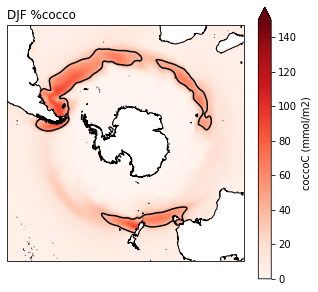

In [24]:
fig = plt.figure(figsize=(18,5))
contour_specs = {'levels': np.arange(-0.6,0.7,0.1)}
siz_lev = [0.5]
############### 
ax = fig.add_subplot(1,3,1, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax.set_title('DJF %cocco', loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_djf.perc_cocco.mean(dim='time'))

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='Reds',vmin=0,vmax=150)

cocco_lev = [40]
lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_djf.perc_cocco.mean(dim='time'))
cs = ax.contour(lon,lat,field, colors='black',
                levels = cocco_lev,
                linewidths = 1.5,
                transform=ccrs.PlateCarree())

ax.coastlines('10m',linewidth=1)
fig.colorbar(pc,extend='max', label='coccoC (mmol/m2)');

### Line function

In [25]:
def make_line(ts1,ts2):
    ### create model line
    slope, intercept, r_value, p_value, std_err = stats.linregress(ts1,ts2)
    val_min = np.int(np.floor(ts1.min().values))
    val_max = np.int(np.ceil(ts1.max().values))
    i=0
    model_yvar = np.empty([val_max-val_min+1])
    for val in np.arange(val_min,val_max+1,1):
        model_yvar[i] = slope * val + intercept
        i = i + 1
    return(val_min,val_max,model_yvar,slope,intercept,r_value,p_value)

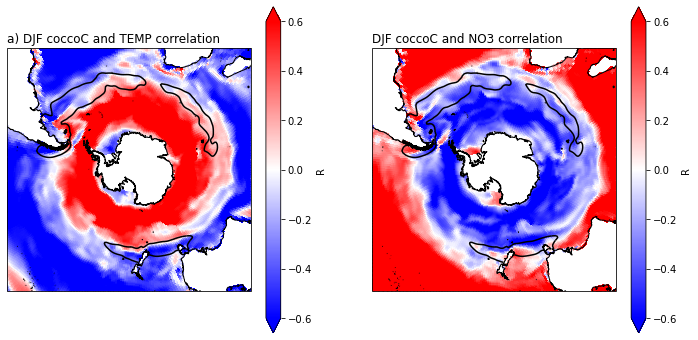

In [26]:
fig = plt.figure(figsize=(12,6))
contour_specs = {'levels': np.arange(-0.6,0.7,0.1)}
siz_lev = [0.5]
# ############### 
# ax = fig.add_subplot(2,2,1, projection=ccrs.SouthPolarStereo())
# ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
# ax.set_title('DJF coccoC and Fe correlation', loc='left')


# corr = xr.corr(ds_djf.coccoC, ds_djf.Fe, dim='time')
# lon,lat,field = utils.adjust_pop_grid(lons, lats, corr)

# pc = ax.pcolormesh(lon,lat,field,
#                     transform=ccrs.PlateCarree(),cmap='bwr',vmin=-0.6,vmax=0.6)

# cocco_lev = [50]
# lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_djf.coccoC.mean(dim='time'))
# cs = ax.contour(lon,lat,field, colors='black',
#                 levels = cocco_lev,
#                 linewidths = 1.5,
#                 transform=ccrs.PlateCarree())

# ax.coastlines('10m',linewidth=1)
# fig.colorbar(pc,extend='both', label='R');

############### 
ax = fig.add_subplot(1,2,1, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax.set_title('a) DJF coccoC and TEMP correlation', loc='left')


corr = xr.corr(ds_djf.coccoC, ds_djf.TEMP, dim='time')
lon,lat,field = utils.adjust_pop_grid(lons, lats, corr)

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='bwr',vmin=-0.6,vmax=0.6)

cocco_lev = [40]
lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_djf.perc_cocco.mean(dim='time'))
cs = ax.contour(lon,lat,field, colors='black',
                levels = cocco_lev,
                linewidths = 1.5,
                transform=ccrs.PlateCarree())

ax.coastlines('10m',linewidth=1)
fig.colorbar(pc,extend='both', label='R');


############### 
ax = fig.add_subplot(1,2,2, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax.set_title('DJF coccoC and NO3 correlation', loc='left')


corr = xr.corr(ds_djf.coccoC, ds_djf.NO3, dim='time')
lon,lat,field = utils.adjust_pop_grid(lons, lats, corr)

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='bwr',vmin=-0.6,vmax=0.6)

cocco_lev = [40]
lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_djf.perc_cocco.mean(dim='time'))
cs = ax.contour(lon,lat,field, colors='black',
                levels = cocco_lev,
                linewidths = 1.5,
                transform=ccrs.PlateCarree())

ax.coastlines('10m',linewidth=1)
fig.colorbar(pc,extend='both', label='R');

############### 
# ax = fig.add_subplot(2,2,4, projection=ccrs.SouthPolarStereo())
# ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
# ax.set_title('DJF coccoC and DIC correlation', loc='left')


# corr = xr.corr(ds_djf.coccoC, ds_djf.DIC, dim='time')
# lon,lat,field = utils.adjust_pop_grid(lons, lats, corr)

# pc = ax.pcolormesh(lon,lat,field,
#                     transform=ccrs.PlateCarree(),cmap='bwr',vmin=-0.6,vmax=0.6)

# cocco_lev = [50]
# lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_djf.coccoC.mean(dim='time'))
# cs = ax.contour(lon,lat,field, colors='black',
#                 levels = cocco_lev,
#                 linewidths = 1.5,
#                 transform=ccrs.PlateCarree())

# ax.coastlines('10m',linewidth=1)
# fig.colorbar(pc,extend='both', label='R');

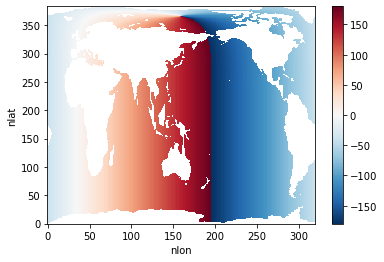

In [27]:
lons_norm.where(ds_grid.REGION_MASK >0).plot()

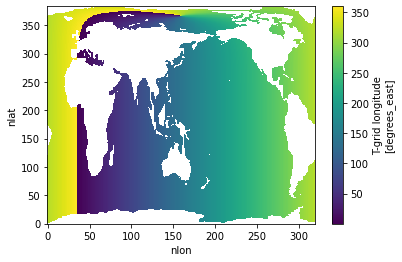

In [28]:
lons.where(ds_grid.REGION_MASK >0).plot()

plot coeff of variation for percent cocco to see if it's the upper boundary or the southern boundary

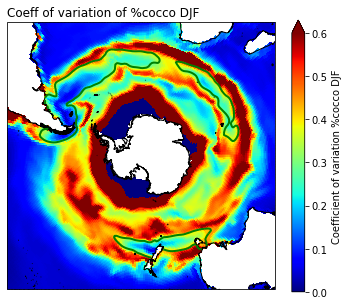

In [29]:
fig = plt.figure(figsize=(6,5))

############### 
ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax.set_title('Coeff of variation of %cocco DJF', loc='left')


lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_djf.perc_cocco.std(dim='time')/ds_djf.perc_cocco.mean(dim='time'))

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='jet',vmin=0,vmax=0.6)

cocco_lev = [40]
lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_djf.perc_cocco.mean(dim='time'))
cs = ax.contour(lon,lat,field, colors='green',
                levels = cocco_lev,
                linewidths = 2,
                transform=ccrs.PlateCarree())

ax.coastlines('10m',linewidth=1)
fig.colorbar(pc,extend='max', label='Coefficient of variation %cocco DJF');


In [41]:
###box 1, northern edge of indian sector
box1_latmin = -42
box1_latmax = -37
box1_lonmin = 60.
box1_lonmax = 80.

###box 2, that blob in the Pacific
box2_latmin = -55
box2_latmax = -50
box2_lonmin = -140.
box2_lonmax = -120.

###box 3, South of GCB, south of NZ
box3_latmin = -57
box3_latmax = -52
box3_lonmin = 160.
box3_lonmax = 175.

###box 4, South of GCB, southern part of Indian sector
box4_latmin = -51
box4_latmax = -47
box4_lonmin = 55.
box4_lonmax = 70.

###box 5, northern edge eastern atlantic just south of Africa
box5_latmin = -42
box5_latmax = -37
box5_lonmin = 5.
box5_lonmax = 20.

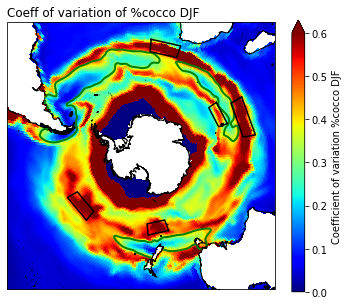

In [42]:
fig = plt.figure(figsize=(6,5))

############### 
ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax.set_title('Coeff of variation of %cocco DJF', loc='left')


lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_djf.perc_cocco.std(dim='time')/ds_djf.perc_cocco.mean(dim='time'))

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='jet',vmin=0,vmax=0.6)

cocco_lev = [40]
lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_djf.perc_cocco.mean(dim='time'))
cs = ax.contour(lon,lat,field, colors='green',
                levels = cocco_lev,
                linewidths = 2,
                transform=ccrs.PlateCarree())


lon_pts = [box1_lonmin,box1_lonmax,box1_lonmax,box1_lonmin,box1_lonmin]
lat_pts = [box1_latmax,box1_latmax,box1_latmin,box1_latmin,box1_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box2_lonmin,box2_lonmax,box2_lonmax,box2_lonmin,box2_lonmin]
lat_pts = [box2_latmax,box2_latmax,box2_latmin,box2_latmin,box2_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box3_lonmin,box3_lonmax,box3_lonmax,box3_lonmin,box3_lonmin]
lat_pts = [box3_latmax,box3_latmax,box3_latmin,box3_latmin,box3_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box4_lonmin,box4_lonmax,box4_lonmax,box4_lonmin,box4_lonmin]
lat_pts = [box4_latmax,box4_latmax,box4_latmin,box4_latmin,box4_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box5_lonmin,box5_lonmax,box5_lonmax,box5_lonmin,box5_lonmin]
lat_pts = [box5_latmax,box5_latmax,box5_latmin,box5_latmin,box5_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

ax.coastlines('10m',linewidth=1)
fig.colorbar(pc,extend='max', label='Coefficient of variation %cocco DJF');


In [43]:
ds_djf['cocco_T_lim'] = 0.12 * ds_djf.TEMP**0.4

In [44]:
ds_clim['cocco_T_lim'] = 0.12 * ds_clim.TEMP**0.4

In [45]:
variables = variables + ['perc_cocco','cocco_T_lim']

In [46]:

ts_box1 = xr.Dataset({v: ds_djf[v] for v in ['time']})
clim_box1 = xr.Dataset({v: ds_clim[v] for v in ['month']})

ts_box2 = xr.Dataset({v: ds_djf[v] for v in ['time']})
clim_box2 = xr.Dataset({v: ds_clim[v] for v in ['month']})

ts_box3 = xr.Dataset({v: ds_djf[v] for v in ['time']})
clim_box3 = xr.Dataset({v: ds_clim[v] for v in ['month']})

ts_box4 = xr.Dataset({v: ds_djf[v] for v in ['time']})
clim_box4 = xr.Dataset({v: ds_clim[v] for v in ['month']})

ts_box5 = xr.Dataset({v: ds_djf[v] for v in ['time']})
clim_box5 = xr.Dataset({v: ds_clim[v] for v in ['month']})

for var in variables:
    
    print(var) 
    
    #### box 1 
    mask = ones.where(lats<box1_latmax).where(lats>box1_latmin).where(lons_norm<box1_lonmax).where(lons_norm>box1_lonmin)
    masked_area = area.where(mask==1)
    masked_var = ds_djf[var].where(mask==1)
    ts_box1[var] = (masked_var * masked_area).sum(dim=('nlon','nlat')) / masked_area.sum(dim=('nlon','nlat'))

    masked_var = ds_clim[var].where(mask==1)
    clim_box1[var] = (masked_var * masked_area).sum(dim=('nlon','nlat')) / masked_area.sum(dim=('nlon','nlat'))

    #### box 2 
    mask = ones.where(lats<box2_latmax).where(lats>box2_latmin).where(lons_norm<box2_lonmax).where(lons_norm>box2_lonmin)
    masked_area = area.where(mask==1)
    masked_var = ds_djf[var].where(mask==1)
    ts_box2[var] = (masked_var * masked_area).sum(dim=('nlon','nlat')) / masked_area.sum(dim=('nlon','nlat'))

    masked_var = ds_clim[var].where(mask==1)
    clim_box2[var] = (masked_var * masked_area).sum(dim=('nlon','nlat')) / masked_area.sum(dim=('nlon','nlat'))
    
    #### box 3 
    mask = ones.where(lats<box3_latmax).where(lats>box3_latmin).where(lons_norm<box3_lonmax).where(lons_norm>box3_lonmin)
    masked_area = area.where(mask==1)
    masked_var = ds_djf[var].where(mask==1)
    ts_box3[var] = (masked_var * masked_area).sum(dim=('nlon','nlat')) / masked_area.sum(dim=('nlon','nlat'))

    masked_var = ds_clim[var].where(mask==1)
    clim_box3[var] = (masked_var * masked_area).sum(dim=('nlon','nlat')) / masked_area.sum(dim=('nlon','nlat'))

    #### box 4 
    mask = ones.where(lats<box4_latmax).where(lats>box4_latmin).where(lons_norm<box4_lonmax).where(lons_norm>box4_lonmin)
    masked_area = area.where(mask==1)
    masked_var = ds_djf[var].where(mask==1)
    ts_box4[var] = (masked_var * masked_area).sum(dim=('nlon','nlat')) / masked_area.sum(dim=('nlon','nlat'))

    masked_var = ds_clim[var].where(mask==1)
    clim_box4[var] = (masked_var * masked_area).sum(dim=('nlon','nlat')) / masked_area.sum(dim=('nlon','nlat'))

    #### box 5 
    mask = ones.where(lats<box5_latmax).where(lats>box5_latmin).where(lons_norm<box5_lonmax).where(lons_norm>box5_lonmin)
    masked_area = area.where(mask==1)
    masked_var = ds_djf[var].where(mask==1)
    ts_box5[var] = (masked_var * masked_area).sum(dim=('nlon','nlat')) / masked_area.sum(dim=('nlon','nlat'))

    masked_var = ds_clim[var].where(mask==1)
    clim_box5[var] = (masked_var * masked_area).sum(dim=('nlon','nlat')) / masked_area.sum(dim=('nlon','nlat'))





PH
SHF_QSW
DIC
NO3
TEMP
HMXL
coccoC
coccoCaCO3
diatC
spC
diatSi
Fe
cocco_Fe_lim_Cweight_avg_100m
cocco_N_lim_Cweight_avg_100m
IRON_FLUX
perc_cocco
cocco_T_lim


### BOX 1

In [71]:
##### box 1 - cocco proportion correlations
for var in variables:
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(ts_box1.perc_cocco, ts_box1[var])
    print(var, '   R = ', np.round(r_value,3), '      p = ', np.format_float_scientific(p_value, precision=3))

PH    R =  -0.264       p =  3.622e-02
SHF_QSW    R =  -0.14       p =  2.739e-01
DIC    R =  0.118       p =  3.550e-01
NO3    R =  -0.328       p =  8.630e-03
TEMP    R =  0.393       p =  1.444e-03
HMXL    R =  -0.172       p =  1.768e-01
coccoC    R =  0.79       p =  1.425e-14
coccoCaCO3    R =  0.786       p =  2.424e-14
diatC    R =  -0.586       p =  4.601e-07
spC    R =  -0.777       p =  7.074e-14
diatSi    R =  -0.573       p =  9.195e-07
Fe    R =  0.124       p =  3.342e-01
cocco_Fe_lim_Cweight_avg_100m    R =  -0.124       p =  3.345e-01
cocco_N_lim_Cweight_avg_100m    R =  -0.484       p =  5.817e-05
IRON_FLUX    R =  0.273       p =  3.021e-02
perc_cocco    R =  1.0       p =  0.e+00
cocco_T_lim    R =  0.392       p =  1.483e-03


In [72]:
##### box 1- cocco biomass correlations
for var in variables:
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(ts_box1.coccoC, ts_box1[var])
    print(var, '      R = ', np.round(r_value,3), '      p = ', np.format_float_scientific(p_value, precision=3))

PH       R =  -0.138       p =  2.820e-01
SHF_QSW       R =  -0.253       p =  4.557e-02
DIC       R =  0.046       p =  7.219e-01
NO3       R =  -0.156       p =  2.229e-01
TEMP       R =  0.211       p =  9.627e-02
HMXL       R =  -0.14       p =  2.726e-01
coccoC       R =  1.0       p =  0.e+00
coccoCaCO3       R =  0.987       p =  2.003e-50
diatC       R =  -0.053       p =  6.796e-01
spC       R =  -0.836       p =  1.580e-17
diatSi       R =  -0.037       p =  7.727e-01
Fe       R =  0.179       p =  1.597e-01
cocco_Fe_lim_Cweight_avg_100m       R =  -0.291       p =  2.069e-02
cocco_N_lim_Cweight_avg_100m       R =  -0.581       p =  5.879e-07
IRON_FLUX       R =  0.229       p =  7.142e-02
perc_cocco       R =  0.79       p =  1.425e-14
cocco_T_lim       R =  0.21       p =  9.837e-02


### BOX 2

In [73]:
##### box 2 - cocco proportion correlations
for var in variables:
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(ts_box2.perc_cocco, ts_box2[var])
    print(var, '      R = ', np.round(r_value,3), '      p = ', np.format_float_scientific(p_value, precision=3))

PH       R =  -0.376       p =  2.421e-03
SHF_QSW       R =  -0.053       p =  6.820e-01
DIC       R =  0.228       p =  7.268e-02
NO3       R =  -0.563       p =  1.597e-06
TEMP       R =  0.558       p =  1.975e-06
HMXL       R =  0.142       p =  2.668e-01
coccoC       R =  0.853       p =  6.457e-19
coccoCaCO3       R =  0.738       p =  5.414e-12
diatC       R =  -0.671       p =  1.728e-09
spC       R =  -0.292       p =  2.022e-02
diatSi       R =  -0.621       p =  5.599e-08
Fe       R =  0.248       p =  4.998e-02
cocco_Fe_lim_Cweight_avg_100m       R =  0.431       p =  4.154e-04
cocco_N_lim_Cweight_avg_100m       R =  -0.798       p =  4.569e-15
IRON_FLUX       R =  -0.055       p =  6.670e-01
perc_cocco       R =  1.0       p =  0.e+00
cocco_T_lim       R =  0.556       p =  2.218e-06


In [74]:
##### box 2 - cocco biomass correlations
for var in variables:
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(ts_box2.coccoC, ts_box2[var])
    print(var, '      R = ', np.round(r_value,3), '      p = ', np.format_float_scientific(p_value, precision=3))

PH       R =  -0.462       p =  1.368e-04
SHF_QSW       R =  -0.135       p =  2.93e-01
DIC       R =  0.366       p =  3.192e-03
NO3       R =  -0.414       p =  7.493e-04
TEMP       R =  0.305       p =  1.491e-02
HMXL       R =  0.182       p =  1.544e-01
coccoC       R =  1.0       p =  0.e+00
coccoCaCO3       R =  0.781       p =  4.417e-14
diatC       R =  -0.255       p =  4.347e-02
spC       R =  -0.208       p =  1.018e-01
diatSi       R =  -0.22       p =  8.285e-02
Fe       R =  0.106       p =  4.063e-01
cocco_Fe_lim_Cweight_avg_100m       R =  0.436       p =  3.507e-04
cocco_N_lim_Cweight_avg_100m       R =  -0.557       p =  2.103e-06
IRON_FLUX       R =  -0.094       p =  4.65e-01
perc_cocco       R =  0.853       p =  6.457e-19
cocco_T_lim       R =  0.301       p =  1.660e-02


### BOX 3

In [75]:
##### box 3 - cocco proportion correlations
for var in variables:
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(ts_box3.perc_cocco, ts_box3[var])
    print(var, '      R = ', np.round(r_value,3), '      p = ', np.format_float_scientific(p_value, precision=3))

PH       R =  0.066       p =  6.099e-01
SHF_QSW       R =  -0.196       p =  1.239e-01
DIC       R =  -0.179       p =  1.599e-01
NO3       R =  -0.497       p =  3.370e-05
TEMP       R =  0.508       p =  2.167e-05
HMXL       R =  0.042       p =  7.426e-01
coccoC       R =  0.91       p =  5.828e-25
coccoCaCO3       R =  0.774       p =  9.812e-14
diatC       R =  -0.596       p =  2.558e-07
spC       R =  -0.595       p =  2.764e-07
diatSi       R =  -0.533       p =  6.883e-06
Fe       R =  0.179       p =  1.611e-01
cocco_Fe_lim_Cweight_avg_100m       R =  0.106       p =  4.062e-01
cocco_N_lim_Cweight_avg_100m       R =  -0.849       p =  1.42e-18
IRON_FLUX       R =  0.156       p =  2.208e-01
perc_cocco       R =  1.0       p =  0.e+00
cocco_T_lim       R =  0.507       p =  2.214e-05


In [76]:
##### box 3 - cocco biomass correlations
for var in variables:
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(ts_box3.coccoC, ts_box3[var])
    print(var, '      R = ', np.round(r_value,3), '      p = ', np.format_float_scientific(p_value, precision=3))

PH       R =  0.049       p =  7.05e-01
SHF_QSW       R =  -0.141       p =  2.713e-01
DIC       R =  -0.125       p =  3.293e-01
NO3       R =  -0.449       p =  2.249e-04
TEMP       R =  0.331       p =  8.011e-03
HMXL       R =  0.004       p =  9.767e-01
coccoC       R =  1.0       p =  0.e+00
coccoCaCO3       R =  0.859       p =  2.270e-19
diatC       R =  -0.293       p =  1.958e-02
spC       R =  -0.59       p =  3.653e-07
diatSi       R =  -0.257       p =  4.192e-02
Fe       R =  0.094       p =  4.624e-01
cocco_Fe_lim_Cweight_avg_100m       R =  0.043       p =  7.365e-01
cocco_N_lim_Cweight_avg_100m       R =  -0.81       p =  9.121e-16
IRON_FLUX       R =  0.185       p =  1.467e-01
perc_cocco       R =  0.91       p =  5.828e-25
cocco_T_lim       R =  0.33       p =  8.172e-03


### BOX 4

In [77]:
##### box 4 - cocco proportion correlations
for var in variables:
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(ts_box4.perc_cocco, ts_box4[var])
    print(var, '      R = ', np.round(r_value,3), '      p = ', np.format_float_scientific(p_value, precision=3))

PH       R =  -0.017       p =  8.926e-01
SHF_QSW       R =  -0.016       p =  9.040e-01
DIC       R =  -0.024       p =  8.536e-01
NO3       R =  -0.306       p =  1.473e-02
TEMP       R =  0.377       p =  2.349e-03
HMXL       R =  -0.285       p =  2.364e-02
coccoC       R =  0.959       p =  5.237e-35
coccoCaCO3       R =  0.781       p =  4.353e-14
diatC       R =  -0.485       p =  5.612e-05
spC       R =  -0.558       p =  2.072e-06
diatSi       R =  -0.391       p =  1.521e-03
Fe       R =  0.012       p =  9.275e-01
cocco_Fe_lim_Cweight_avg_100m       R =  -0.225       p =  7.561e-02
cocco_N_lim_Cweight_avg_100m       R =  -0.843       p =  4.654e-18
IRON_FLUX       R =  -0.054       p =  6.732e-01
perc_cocco       R =  1.0       p =  0.e+00
cocco_T_lim       R =  0.369       p =  2.899e-03


In [78]:
##### box 4 - cocco biomass correlations
for var in variables:
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(ts_box4.coccoC, ts_box4[var])
    print(var, '      R = ', np.round(r_value,3), '      p = ', np.format_float_scientific(p_value, precision=3))

PH       R =  -0.157       p =  2.198e-01
SHF_QSW       R =  -0.007       p =  9.567e-01
DIC       R =  0.136       p =  2.868e-01
NO3       R =  -0.266       p =  3.529e-02
TEMP       R =  0.287       p =  2.252e-02
HMXL       R =  -0.314       p =  1.226e-02
coccoC       R =  1.0       p =  0.e+00
coccoCaCO3       R =  0.727       p =  1.448e-11
diatC       R =  -0.24       p =  5.809e-02
spC       R =  -0.506       p =  2.357e-05
diatSi       R =  -0.181       p =  1.546e-01
Fe       R =  0.08       p =  5.353e-01
cocco_Fe_lim_Cweight_avg_100m       R =  -0.155       p =  2.239e-01
cocco_N_lim_Cweight_avg_100m       R =  -0.844       p =  3.986e-18
IRON_FLUX       R =  0.077       p =  5.507e-01
perc_cocco       R =  0.959       p =  5.237e-35
cocco_T_lim       R =  0.281       p =  2.590e-02


### BOX 5

In [79]:
##### box 5 cocco proportion correlations
for var in variables:
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(ts_box5.perc_cocco, ts_box5[var])
    print(var, '      R = ', np.round(r_value,3), '      p = ', np.format_float_scientific(p_value, precision=3))

PH       R =  -0.039       p =  7.627e-01
SHF_QSW       R =  -0.129       p =  3.152e-01
DIC       R =  -0.04       p =  7.547e-01
NO3       R =  -0.099       p =  4.414e-01
TEMP       R =  -0.101       p =  4.327e-01
HMXL       R =  0.133       p =  2.979e-01
coccoC       R =  0.902       p =  5.729e-24
coccoCaCO3       R =  0.928       p =  6.699e-28
diatC       R =  -0.358       p =  4.012e-03
spC       R =  -0.756       p =  7.689e-13
diatSi       R =  -0.316       p =  1.162e-02
Fe       R =  -0.253       p =  4.556e-02
cocco_Fe_lim_Cweight_avg_100m       R =  -0.64       p =  1.680e-08
cocco_N_lim_Cweight_avg_100m       R =  -0.383       p =  1.971e-03
IRON_FLUX       R =  -0.136       p =  2.881e-01
perc_cocco       R =  1.0       p =  0.e+00
cocco_T_lim       R =  -0.108       p =  3.999e-01


In [80]:
##### box 5 - cocco biomass correlations
for var in variables:
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(ts_box5.coccoC, ts_box5[var])
    print(var, '      R = ', np.round(r_value,3), '      p = ', np.format_float_scientific(p_value, precision=3))

PH       R =  -0.042       p =  7.43e-01
SHF_QSW       R =  -0.139       p =  2.767e-01
DIC       R =  -0.001       p =  9.916e-01
NO3       R =  -0.032       p =  8.014e-01
TEMP       R =  -0.122       p =  3.410e-01
HMXL       R =  -0.012       p =  9.242e-01
coccoC       R =  1.0       p =  0.e+00
coccoCaCO3       R =  0.981       p =  5.368e-45
diatC       R =  -0.052       p =  6.865e-01
spC       R =  -0.735       p =  7.248e-12
diatSi       R =  -0.025       p =  8.485e-01
Fe       R =  -0.177       p =  1.644e-01
cocco_Fe_lim_Cweight_avg_100m       R =  -0.667       p =  2.410e-09
cocco_N_lim_Cweight_avg_100m       R =  -0.497       p =  3.413e-05
IRON_FLUX       R =  -0.166       p =  1.945e-01
perc_cocco       R =  0.902       p =  5.729e-24
cocco_T_lim       R =  -0.131       p =  3.066e-01


### plot a few climatologies

### N lim

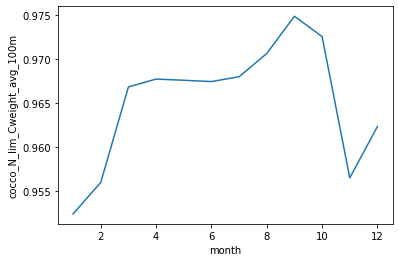

In [69]:
clim_box1.cocco_N_lim_Cweight_avg_100m.plot()

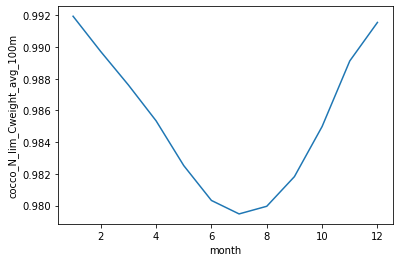

In [70]:
clim_box2.cocco_N_lim_Cweight_avg_100m.plot()

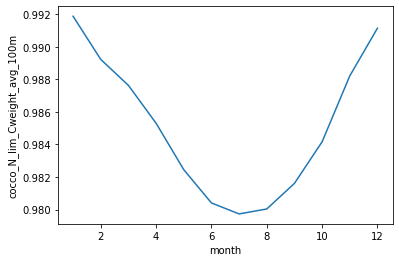

In [71]:
clim_box3.cocco_N_lim_Cweight_avg_100m.plot()

### Fe lim

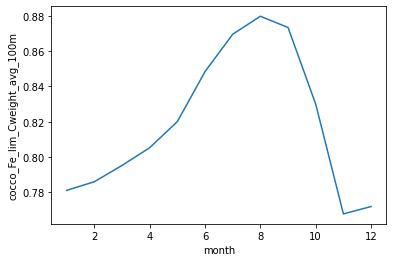

In [73]:
clim_box1.cocco_Fe_lim_Cweight_avg_100m.plot()

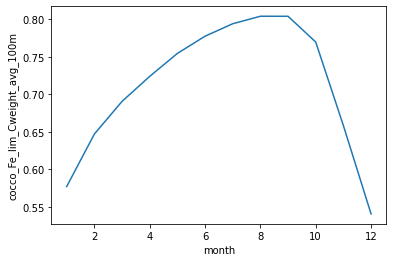

In [74]:
clim_box2.cocco_Fe_lim_Cweight_avg_100m.plot()

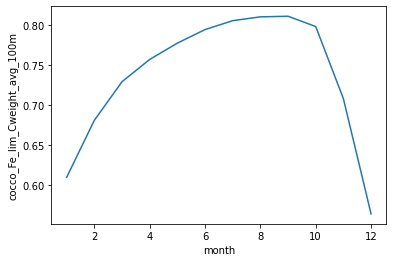

In [75]:
clim_box3.cocco_Fe_lim_Cweight_avg_100m.plot()

### T lim

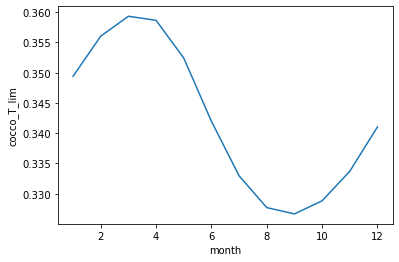

In [77]:
clim_box1.cocco_T_lim.plot()

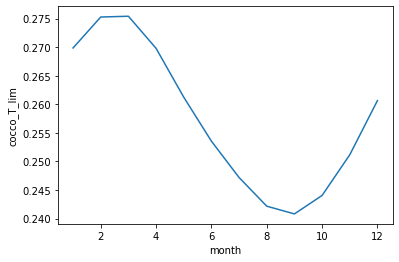

In [78]:
clim_box2.cocco_T_lim.plot()

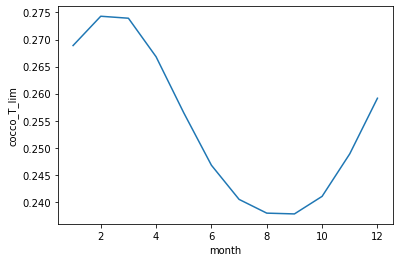

In [79]:
clim_box3.cocco_T_lim.plot()